In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy
import seaborn
import pathlib
import geopandas
import pandas
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in surveyed elevation cross sections and riverbanks
  * Use the delineated riverbanks to define the area
  * Use river estimation cross sections to define sample locations
* Load in the DEMs
  * Unconditioned, interpolated riverbed, and 2 methods of estimated riverbed
* Calculate depths (within the delineated river)
  * Mean DEM depths at regular profiles along the river (multiples of the 10m profile spacing)
  * Plot the surveyed elevations as boxplots
* Calculate the areas (within the delineated river) based on the riverbed estimation water surface height 
  * Line plots for DEMs
  * Point plot for surveyed measurements

In [2]:
upstream_spacing = 10
horizontal_crs = 2193

# Read in data
## Load in GeoFabrics data
DEMS

In [3]:
cache_path = pathlib.Path(r"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
dems = {}
dems["Unconditioned"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_unconditioned.nc", masked=True).squeeze("band", drop=True)
dems["Conceptual Multivariate Regression Approach"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_rupp_and_smart_smooth.nc", masked=True).squeeze("band", drop=True)
dems["Uniform Flow Approach"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_neal_et_al_smooth.nc", masked=True).squeeze("band", drop=True)
dems["Interpolated Surveyed Elevation Cross Sections"] = rioxarray.rioxarray.open_rasterio(cache_path / folder / "geofabric_8m_measured_river_fan.nc", masked=True).squeeze("band", drop=True)

## Delineated river polygon
And the 'River Estimation' profiles and water elevation estimation

In [4]:
sampled_sections = geopandas.read_file(cache_path / folder / "river" / "final_cross_sections.geojson")
sampled_sections = sampled_sections.drop(columns=['min_z_centre', 'min_z_centre_unimodal', 'slope',
       'min_z_centre_unimodal_mean_0.05km', 'slope_mean_0.05km', 'first_bank_i', 'last_bank_i',
       'min_z_centre_unimodal_mean_0.25km', 'slope_mean_0.25km', 'first_flat_bank_i', 'last_flat_bank_i',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km', 'widths',
       'threshold', 'channel_count', 'flat_widths', 'valid', 'valid_widths',
       'valid_flat_widths', 'valid_threhold', 'widths_mean_0.05km',
       'flat_widths_mean_0.05km', 'thresholds_mean_0.05km',
       'widths_mean_0.15km', 'flat_widths_mean_0.15km',
       'thresholds_mean_0.15km', 'widths_mean_0.2km', 'flat_widths_mean_0.2km',
       'thresholds_mean_0.2km', 'widths_mean_0.25km',
       'flat_widths_mean_0.25km', 'thresholds_mean_0.25km'])

polygon = geopandas.read_file(cache_path / folder / "measured_river" / "river_polygon.geojson")
sampled_sections['Distance Upstream [m]'] = sampled_sections.index * upstream_spacing
sampled_sections = sampled_sections.clip(polygon).sort_index().reset_index(drop=True)
sampled_sections = sampled_sections.set_index(keys=["Distance Upstream [m]"])

<Axes: >

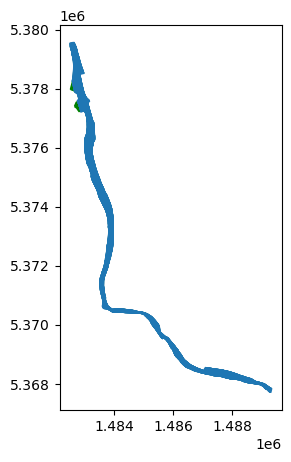

In [5]:
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
polygon.plot(ax=ax, color='g')
sampled_sections.plot(ax=ax)

## Surveyed cross section elevations
Note have already been processed into expected form

In [6]:
sections_path = pathlib.Path(r"C:\Local\data\catchments\measured_sections\westport")
surveyed_name_label = 'Name'
surveyed_sections = geopandas.read_file(sections_path / "measured_sections.geojson")
surveyed_sections = surveyed_sections.clip(polygon).sort_index()

### Add distance upstream to surveyed data

In [7]:
distance_upstream = []
for section in surveyed_sections.geometry:
    distance_upstream.append(sampled_sections.distance(section).idxmin())
surveyed_sections['Distance Upstream [m]'] = distance_upstream

# Calculate elevations and areas

### Calculate for surveyed sections
Create a DF with a row for each 1m along each profile

In [8]:
surveyed_expanded = {"Riverbed Elevation [m]": [], "Distance Upstream [m]": [], "Offset [m]": [], "Water elevation [m]": []}
for index, row in surveyed_sections.iterrows():
    #print(f"Section number = {index} of {len(surveyed_sections)}")
    line = row.geometry
    distance_upstream = row["Distance Upstream [m]"]
    for offset in numpy.arange(line.length + 1):
        point = line.interpolate(offset)
        surveyed_expanded["Distance Upstream [m]"].append(distance_upstream)
        surveyed_expanded["Offset [m]"].append(offset)
        surveyed_expanded["Riverbed Elevation [m]"].append(point.z)
        surveyed_expanded["Water elevation [m]"].append(sampled_sections.loc[distance_upstream]['min_z_water'])
        
surveyed_expanded = pandas.DataFrame.from_dict(surveyed_expanded)

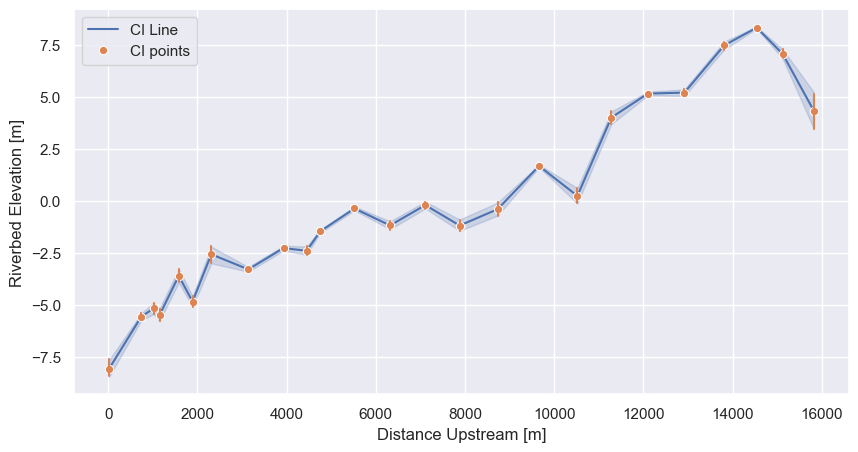

In [9]:
seaborn.set(rc={'figure.figsize':(10,5)})
figure = seaborn.lineplot(data=surveyed_expanded, x="Distance Upstream [m]", y="Riverbed Elevation [m]", label='CI Line')
figure = seaborn.lineplot(data=surveyed_expanded, x="Distance Upstream [m]", y="Riverbed Elevation [m]", err_style='bars',
                          marker='o', linestyle='', label='CI points')

## Sample DEM elevations
Sample along the profiles generated in the 'River Estimation' process within the delineated river polygon
Create a DF with a row for each 1m along each profile

# Sample every 1m
Use Linear interpolation in between

In [20]:
df = sampled_sections#.iloc[::100]
sampled_expanded = {**dict((f"{key}", []) for key in dems), "Distance Upstream [m]": [], "Offset [m]": [], "Water elevation [m]": []}
for distance_upstream, row in df.iterrows():
    print(f"Distance upstream = {distance_upstream}m of {max(df.index)}m")
    line = row.geometry
    water_elevation = row['min_z_water']
    for offset in numpy.arange(line.length + 1):
        point = line.interpolate(offset)
        for key in dems:
            sampled_expanded[f"{key}"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        sampled_expanded["Distance Upstream [m]"].append(distance_upstream)
        sampled_expanded["Offset [m]"].append(offset)
        sampled_expanded["Water elevation [m]"].append(water_elevation)
        
sampled_expanded = pandas.DataFrame.from_dict(sampled_expanded)

Distance upstream = 0m of 15910m
Distance upstream = 10m of 15910m
Distance upstream = 20m of 15910m
Distance upstream = 30m of 15910m
Distance upstream = 40m of 15910m
Distance upstream = 50m of 15910m
Distance upstream = 60m of 15910m
Distance upstream = 70m of 15910m
Distance upstream = 80m of 15910m
Distance upstream = 90m of 15910m
Distance upstream = 100m of 15910m
Distance upstream = 110m of 15910m
Distance upstream = 120m of 15910m
Distance upstream = 130m of 15910m
Distance upstream = 140m of 15910m
Distance upstream = 150m of 15910m
Distance upstream = 160m of 15910m
Distance upstream = 170m of 15910m
Distance upstream = 180m of 15910m
Distance upstream = 190m of 15910m
Distance upstream = 200m of 15910m
Distance upstream = 210m of 15910m
Distance upstream = 220m of 15910m
Distance upstream = 230m of 15910m
Distance upstream = 240m of 15910m
Distance upstream = 250m of 15910m
Distance upstream = 260m of 15910m
Distance upstream = 270m of 15910m
Distance upstream = 280m of 159

In [21]:
sampled_expanded.to_json(cache_path / folder / "sampled_section_comparison" / "sampled_values.json")

In [22]:
sampled_expanded = pandas.read_json(cache_path / folder / "sampled_section_comparison" / "sampled_values.json")

# Plot cross sectional elevations
Plot the DEM elevations on each sample compared with the measured sections  by distance upstream

In [23]:
df_for_plotting=sampled_expanded.drop(columns=["Water elevation [m]"]).melt(
    id_vars=["Distance Upstream [m]", "Offset [m]"], var_name="Source", value_name="Riverbed Elevation [m]")

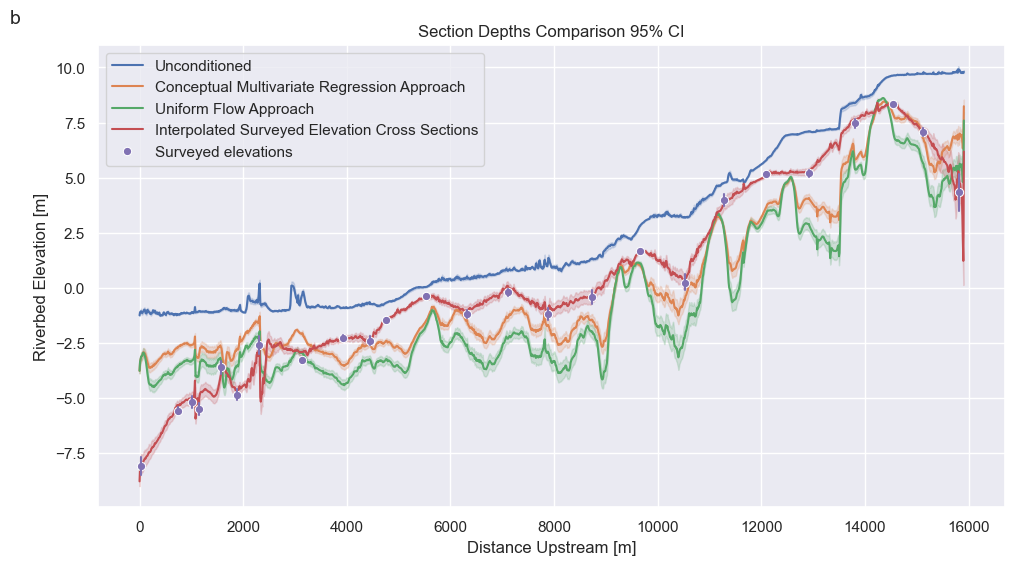

In [24]:
seaborn.set(rc={'figure.figsize':(11.7,6)})
figure = seaborn.lineplot(data=df_for_plotting, x="Distance Upstream [m]", y="Riverbed Elevation [m]", hue="Source")
figure = seaborn.lineplot(data=surveyed_expanded, x="Distance Upstream [m]", y="Riverbed Elevation [m]", err_style='bars',
                          marker='o', linestyle='', label='Surveyed elevations')
figure.set(title='Section Depths Comparison 95% CI')
figure.text(-2500, 12, "b", fontsize=14)
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_depths.png") 

# Plot cross sectional area
Plot the cross sectional area of each DEM and the surveyed sections by distance upstream

In [25]:
sampled_areas = sampled_expanded.set_index(keys=["Distance Upstream [m]", "Offset [m]"])
sampled_areas = -sampled_areas[dems.keys()].sub(sampled_areas['Water elevation [m]'], axis='index') # minus as actually want positive areas 

In [26]:
surveyed_areas = surveyed_expanded.set_index(keys=["Distance Upstream [m]", "Offset [m]"])
surveyed_areas = surveyed_areas['Water elevation [m]'] - surveyed_areas["Riverbed Elevation [m]"]

In [27]:
df_for_plotting = sampled_areas.groupby("Distance Upstream [m]").sum()
df_for_plotting = df_for_plotting.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

In [28]:
surveyed_df_for_plotting = surveyed_areas.groupby("Distance Upstream [m]").sum()

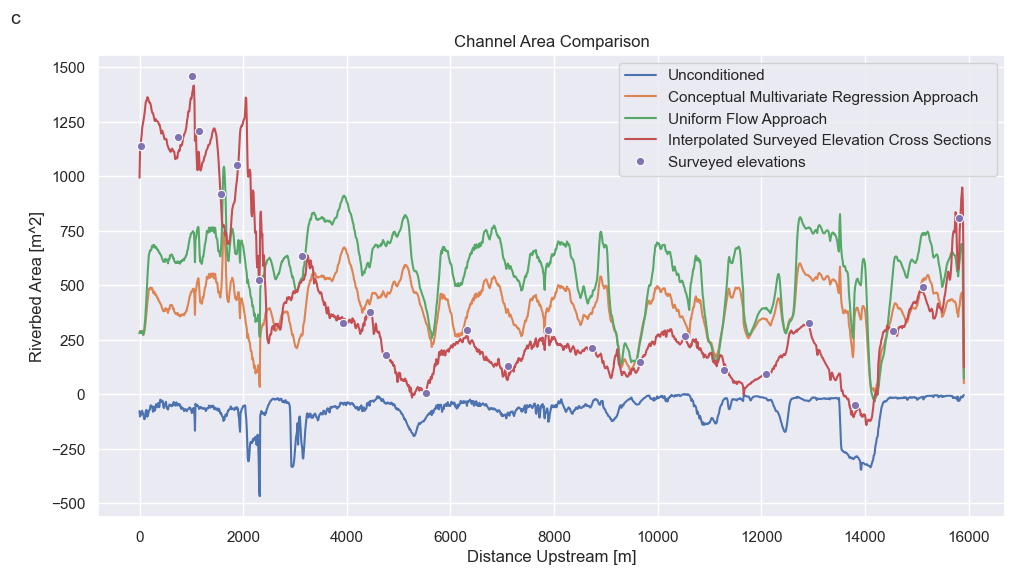

In [29]:
seaborn.set(rc={'figure.figsize':(11.7,6)})
figure = seaborn.lineplot(data=df_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
figure = seaborn.lineplot(data=surveyed_df_for_plotting, marker='o', linestyle='', label='Surveyed elevations')
figure.set(title='Channel Area Comparison')
figure.text(-2500, 1700, "c", fontsize=14)
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 

# Subtract from maximum Surveyed

In [ ]:
maximum_elevations = sampled_expanded.groupby("Distance Upstream [m]")["Interpolated Surveyed Elevation Cross Sections"].max(numeric_only = True)
sampled_expanded["Maximum elevation [m]"] = pandas.Series(sampled_areas.index.get_level_values(0)).map(s).values

In [ ]:
sampled_areas = sampled_expanded.set_index(keys=["Distance Upstream [m]", "Offset [m]"])
sampled_areas = -sampled_areas[dems.keys()].sub(sampled_areas['Maximum elevation [m]'], axis='index') # minus as actually want positive areas

In [ ]:
df_for_plotting = sampled_areas.groupby("Distance Upstream [m]").sum()
df_for_plotting = df_for_plotting.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

In [ ]:
seaborn.set(rc={'figure.figsize':(11.7,6)})
figure = seaborn.lineplot(data=df_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
#figure = seaborn.lineplot(data=surveyed_df_for_plotting, marker='o', linestyle='', label='Surveyed elevations')
figure.set(title='Channel Area Comparison')
figure.text(-2000, 3000, "a", fontsize=14)
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 